# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dependencies

In [ ]:
# !pip install medcam

In [ ]:
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
from math import floor

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm.notebook import tqdm, trange

from torchvision import models
from torchvision.transforms import RandomErasing
from torchsummary import summary

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# from medcam import medcam
from math import prod

# softmax = torch.nn.Softmax(dim=1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.get_num_threads()

(device(type='cuda'), 1)

# Data Loader

In [ ]:
class PassBlockDataset(Dataset):
  def __init__(self, data=None, labels=None, truncate=False, samples=1, scale=1):

    if data is None:
      self.df = pd.read_csv('/content/drive/MyDrive/big data bowl/playtensor.csv')
      self.labels = pd.read_csv('/content/drive/MyDrive/big data bowl/uid_labels.csv')
    else: 
      self.df = data
      self.labels = labels

    # self.xdim = max(self.df.x)+1
    # self.ydim = max(self.df.y)+1
    # self.tdim = max(self.df.t)+1

    self.xdim = 368
    self.ydim = 560
    self.tdim = 112

    self.samples = samples
    self.nplays = len(self.labels)

    self.truncate = truncate
    self.scale = scale

    self.maxtimes = np.random.randint(0, np.tile(self.labels.maxtime, self.samples))   

  def __len__(self):
    return self.nplays * self.samples
    
  def __getitem__(self, idx):   
    if idx >= self.nplays:
      new_idx =  idx % self.nplays
    else:
      new_idx = idx

    current_uid = self.labels.iloc[new_idx].uid
    playdata = self.df.query('uid == @current_uid')

    label = self.labels.iloc[new_idx].clean

    if self.truncate:
      new_maxtime = self.maxtimes[idx]
      playdata = playdata.query('t <= @new_maxtime')

    play = torch.zeros(2, self.xdim, self.ydim, self.tdim).to(device)
    # play = torch.zeros(2, 368, 560, 112, dtype=torch.float16).to(device)
        
    for index, row in playdata.iterrows():
      cx = row['x']
      cy = row['y']
      ct = row['t']
      
      co = row['offense']
      cp = row['pass_or_def']
      play[0][cx][cy][ct] = co
      play[1][cx][cy][ct] = cp

    play = nn.functional.interpolate(play, scale_factor = self.scale)

    # for the two channels (a,b), each voxel is encoded such that
    # (offense , passer or rusher) - pff_role 
    # (0,0) - no player
    # (0,1) - pass rush
    # (1,0) - pass block
    # (1,1) - pass

    return play, label

# Network Architecture

## Small CNN

In [ ]:
# 325x503x92
# 66x99x92

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
   
    self.conv1 = nn.Conv3d(in_channels=2, out_channels=16, kernel_size=10, stride=5, padding = (0,0,0))
    self.bn1 = nn.BatchNorm3d(16)
    self.pool1 = nn.AdaptiveMaxPool3d(output_size = (32,48,48))
  
    self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding = (0,0,0))
    self.bn2 = nn.BatchNorm3d(32)
    self.pool2 = nn.AdaptiveMaxPool3d(output_size = (8,16,16))
    
    self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding = (0,0,0))
    self.bn3 = nn.BatchNorm3d(64)
    self.pool3 = nn.AdaptiveMaxPool3d(output_size = (4,6,6))
    
    self.dropout25 = nn.Dropout(0.25)
    self.dropout50 = nn.Dropout(0.50)
    
    self.fc1 = nn.Linear(9216, 32)
    self.fc2 = nn.Linear(32, 2)
    
  def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = F.relu(x)
      x = self.pool1(x)
      x = self.dropout25(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = F.relu(x)
      x = self.pool2(x)
      x = self.dropout25(x)
      x = self.conv3(x)
      x = self.bn3(x)
      x = F.relu(x)
      x = self.pool3(x)
      x = self.dropout25(x)
      x = torch.flatten(x, 1)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout50(x)
      x = self.fc2(x)
      x = F.softmax(x, dim=1)
      return x

# Training Parameters

In [ ]:
# training parameters
truncate = True
samples = 1
batch_size = 32
scale = 0.75

# Load Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/big data bowl/playtensor.csv')
labels = pd.read_csv('/content/drive/MyDrive/big data bowl/uid_labels.csv')

train_uid, validation_uid = train_test_split(labels.uid, test_size=0.3, random_state=4133)
validation_uid, test_uid = train_test_split(validation_uid, test_size=0.3, random_state=4133)

train_df = df[df['uid'].isin(train_uid)]
validation_df = df[df['uid'].isin(validation_uid)]
test_df = df[df['uid'].isin(test_uid)]

train_labels = labels[labels['uid'].isin(train_uid)]
validation_labels = labels[labels['uid'].isin(validation_uid)]
test_labels = labels[labels['uid'].isin(test_uid)]

train_ds = PassBlockDataset(train_df, train_labels, truncate=truncate, samples=samples, scale=scale)
val_ds = PassBlockDataset(validation_df, validation_labels, truncate=truncate, samples=samples, scale=scale)
test_ds = PassBlockDataset(test_df, test_labels, truncate=truncate, samples=samples, scale=scale)

train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size = batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size = batch_size, shuffle=True, num_workers=0)

In [ ]:
print('xdim: ' + str(train_ds.xdim) + '\n' + 
      'ydim: ' + str(train_ds.ydim) + '\n' +
      'tdim: ' + str(train_ds.tdim) + '\n' )

xdim: 368
ydim: 560
tdim: 112



In [ ]:
# net = DenseNet3D(num_init_features=16, growth_rate=2, block_config=(2, 2), drop_rate=0.2, num_classes=2).to(device)
# net = DenseNet3D(num_init_features=96, growth_rate=2, block_config=(6, 12, 36), drop_rate=0.2, num_classes=2).to(device)
# net = models.video.r2plus1d_18().to(device)

net = CNN().to(device)

# net.load_state_dict(torch.load('/content/drive/MyDrive/big data bowl/cnn_celebrimbor_augmented_005epoch.pt'))

# net.load_state_dict(torch.load('/content/drive/MyDrive/big data bowl/cnn_celebrimbor_4epoch.pt'))

# 325x503x92

In [ ]:
summary(net, (2, test_ds.xdim, test_ds.ydim, test_ds.tdim))

In [ ]:
def train(model, device, train_loader, val_loader, epochs, ce_weights=torch.tensor([1,1], dtype=torch.float16), prior_train = None):
    
    criterion = nn.CrossEntropyLoss(weight=ce_weights)

    optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0001)

    if prior_train is not None:
        train_loss, train_f1, val_loss, val_f1 = prior_train
    else: 
        train_loss, val_loss = [], []
        train_f1, val_f1 = [], []

    for epoch in range(epochs):
        print('Epoch:' + str(epoch))
        model.train()
        running_loss = 0.
        total_clean, total_predicted_clean, total_correct_clean = 0, 0, 0
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)

                optimizer.zero_grad()
                output = model(data).to(device)
                
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total_predicted_clean += (predicted == 1).sum().item()
                total_clean += (target == 1).sum().item()
                total_correct_clean += ((target == 1) & (predicted == 1)).sum().item()
        
        train_loss.append(running_loss/len(train_loader))
        precision = total_correct_clean / total_predicted_clean
        recall = total_correct_clean / total_clean
        train_f1.append(2*(precision*recall)/(precision+recall))
                
        # evaluate on validation data
        model.eval()
        running_loss = 0.
        total_clean, total_predicted_clean, total_correct_clean = 0, 0, 0
        with tqdm(val_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total_predicted_clean += (predicted == 1).sum().item()
                total_clean += (target == 1).sum().item()
                total_correct_clean += ((target == 1) & (predicted == 1)).sum().item()

        val_loss.append(running_loss/len(val_loader))

        precision = total_correct_clean / total_predicted_clean
        recall = total_correct_clean / total_clean
        val_f1.append(2*(precision*recall)/(precision+recall))

        torch.save(net.state_dict(), '/content/drive/MyDrive/big data bowl/cnn_feanor_' + str(epoch) + '.pt')
    
    return train_loss, train_f1, val_loss, val_f1

In [ ]:
clean_pct = sum(labels.clean)/len(labels)
dirty_pct = 1 - clean_pct
print('Clean: ' + str(round(100*clean_pct)) + '%\tDirty: ' + str(round(100*dirty_pct)) + '%')

Clean: 64%	Dirty: 36%


In [ ]:
total_samples = len(labels)
total_clean = sum(labels.clean)
class_frequency = torch.tensor([total_samples-total_clean, total_clean])
class_weights = torch.tensor([total_samples / (2 * class_frequency[c]) for c in range(2)]).to(device)

In [ ]:
# normal
train_loss, train_f1, val_loss, val_f1 = train(net, device, train_loader, val_loader, epochs=12, ce_weights = class_weights)
# train_loss, train_f1, val_loss, val_f1 = train(net, device, train_loader, val_loader, epochs=1, ce_weights = class_weights, prior_train = (train_loss, train_f1, val_loss, val_f1))
# torch.save(net.state_dict(), '/content/drive/MyDrive/big data bowl/cnn_feanor_6epoch.pt')

# # several epochs at a time and save the intermediate models
# train_loss, val_loss = [], []
# train_f1, val_f1 = [], []
# increment = 1
# maxepoch = 10
# start_epoch = 8       #usually 1

# for totalepoch in range(start_epoch, maxepoch, increment):
#   train_loss, train_f1, val_loss, val_f1 = train(net, device, train_loader, val_loader, epochs=increment, ce_weights = class_weights, prior_train = (train_loss, train_f1, val_loss, val_f1))
#   torch.save(net.state_dict(), '/content/drive/MyDrive/big data bowl/cnn_celebrimbor_augmented_' + str((f"{totalepoch:03d}")) + 'epoch.pt')

# smaller dataset for debug
# train_loss, train_f1, val_loss, val_f1 = train(net, device, val_loader, test_loader, epochs=9, ce_weights = class_weights) # smaller set for debugging

Epoch:0


  0%|          | 0/176 [00:00<?, ?batch/s]

  0%|          | 0/53 [00:00<?, ?batch/s]

Epoch:1


  0%|          | 0/176 [00:00<?, ?batch/s]

  0%|          | 0/53 [00:00<?, ?batch/s]

Epoch:2


  0%|          | 0/176 [00:00<?, ?batch/s]

  0%|          | 0/53 [00:00<?, ?batch/s]

Epoch:3


  0%|          | 0/176 [00:00<?, ?batch/s]

  0%|          | 0/53 [00:00<?, ?batch/s]

Epoch:4


  0%|          | 0/176 [00:00<?, ?batch/s]

  0%|          | 0/53 [00:00<?, ?batch/s]

Epoch:5


  0%|          | 0/176 [00:00<?, ?batch/s]

  0%|          | 0/53 [00:00<?, ?batch/s]

Epoch:6


  0%|          | 0/176 [00:00<?, ?batch/s]

  0%|          | 0/53 [00:00<?, ?batch/s]

Epoch:7


  0%|          | 0/176 [00:00<?, ?batch/s]

  0%|          | 0/53 [00:00<?, ?batch/s]

Epoch:8


  0%|          | 0/176 [00:00<?, ?batch/s]

  0%|          | 0/53 [00:00<?, ?batch/s]

Epoch:9


  0%|          | 0/176 [00:00<?, ?batch/s]

  0%|          | 0/53 [00:00<?, ?batch/s]

Epoch:10


  0%|          | 0/176 [00:00<?, ?batch/s]

  0%|          | 0/53 [00:00<?, ?batch/s]

Epoch:11


  0%|          | 0/176 [00:00<?, ?batch/s]

  0%|          | 0/53 [00:00<?, ?batch/s]

In [ ]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training F1')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation F1')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('F1')
    ax2.set_title('Epoch vs F1')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

def test(model, device, data_loader):
    model.eval()
    total_clean, total_predicted_clean, total_correct_clean = 0, 0, 0
    all_predicted = []

    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total_predicted_clean += (predicted == 1).sum().item()
        total_clean += (labels == 1).sum().item()
        total_correct_clean += ((labels == 1) & (predicted == 1)).sum().item()

        all_predicted.append(predicted)

    
    precision = total_correct_clean / total_predicted_clean
    recall = total_correct_clean / total_clean
    test_f1 = 2*(precision*recall)/(precision+recall)
    return test_f1, all_predicted

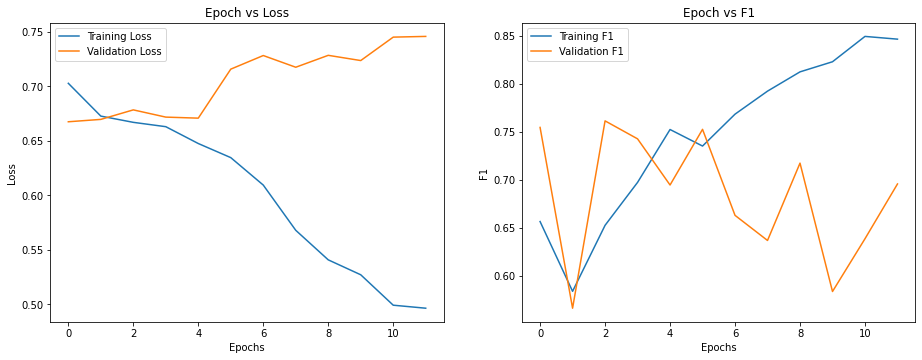

In [ ]:
plot_loss_accuracy(train_loss, train_f1, val_loss, val_f1)

In [ ]:
pd.DataFrame({'train_loss':train_loss, 'train_f1':train_f1, 'val_loss':val_loss, 'val_f1':val_f1}).to_pickle('/content/drive/MyDrive/big data bowl/train_feanor_trunc.pkl')

In [ ]:
# net.load_state_dict(torch.load('/content/drive/MyDrive/big data bowl/cnn_celebrimbor_augmented_005epoch.pt'))
test_f1, pred = test(net, device, test_loader)

test_f1

0.7005181347150259